In [1]:
import numpy as np
import pandas as pd
import requests as requests
from io import StringIO
import csv
import os
from datetime import datetime
import pytz
from time import time
import matplotlib.pyplot as plt

In [2]:
# Create empty dataframe
df = pd.DataFrame()

In [3]:
# Data pulling function from url, where we can find data about Berlin bikes thief record from 01/01/2021-up to today.
# The data are updated everyday or at least once a two/three day, so when we run function the date are expand on new records.

def data_pulling_function():
    global df
    url = "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"
    response = requests.get(url)
    df_raw = pd.read_csv(StringIO(response.text))
    local_time = datetime.now(pytz.timezone('Europe/Warsaw'))
    df = df.append(df_raw)
    pd.set_option('display.max_columns', None)
    print('Data update - {}'.format(local_time.strftime("%Y-%m-%d %H:%M:%S")))
    return df

data_pulling_function()

Data updated - 2022-07-12 19:16:45


C:\Users\dell\AppData\Local\Temp/ipykernel_12804/3407847312.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_raw)


,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND
0,11.07.2022,10.07.2022,13,10.07.2022,22,1401048,429,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
1,11.07.2022,08.07.2022,10,08.07.2022,19,3300514,644,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
2,11.07.2022,11.07.2022,10,11.07.2022,10,3601139,0,Nein,Damenfahrrad,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern
3,11.07.2022,10.07.2022,18,11.07.2022,15,2300417,560,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4,11.07.2022,11.07.2022,13,11.07.2022,14,3601243,2960,Nein,diverse Fahrräder,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
...,...,...,...,...,...,...,...,...,...,...,...
30543,02.01.2021,02.01.2021,13,02.01.2021,13,8401243,1700,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
30544,01.01.2021,01.01.2021,20,01.01.2021,20,2100104,2800,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
30545,01.01.2021,01.01.2021,5,01.01.2021,8,10400941,2527,Nein,diverse Fahrräder,Keller- und Bodeneinbruch,Sonstiger schwerer Diebstahl in/aus Keller/Bod...
30546,01.01.2021,01.01.2021,17,01.01.2021,18,8401241,888,Nein,Fahrrad,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern


In [4]:
# Change columns names

df.columns = ["Record_date", "Stealing_date", "Stealing_hour", "Report_stealing_date",
              "Report_stealing_hour", "Berlin_code_area", "Bike_value", "Unsuccesful_attempt",
              "Bike_type", "Crime_type", "Crime_reason"]

# Change data category in Unsuccesful_attempt for three categories and change column name to english

df["Unsuccesful_attempt"].replace({'Nein' : 'No', 'Ja' : 'Yes', 'Unbekannt' : 'Unknown'}, inplace=True)

# Merge two category "Fahrrad" and "diverse Fahrrader" as one category "Bike" and change column name to english

df["Bike_type"].replace({"Herrenfahrrad" : "Men", "Damenfahrrad" : "Women", "Fahrrad" : "Bike", "Mountainbike" : "Mountain",
                         "Kinderfahrrad" : "Child", "diverse Fahrräder" : "Bike", "Rennrad" : "Racing", "Lastenfahrrad" : "Cargo"}, inplace=True)

# Change column Crime_type vales for english

df["Crime_type"].replace(to_replace=["Fahrraddiebstahl", "Keller- und Bodeneinbruch"], value=["Theft", "Break-in"], inplace=True)

# Change type of category crime_reason to english
# Category "aggrevated theft" = theft with break-in, theft with robbery (aggresor has to use force) 

df["Crime_reason"].replace(to_replace=["Sonstiger schwerer Diebstahl von Fahrrädern", 
                                       "Einfacher Diebstahl von Fahrrädern",
                                       "Sonstiger schwerer Diebstahl in/aus Keller/Boden von Fahrrädern", 
                                       "Einfacher Diebstahl aus Keller/Boden von Fahrrädern"],
                           value=["Aggravated theft", "Theft", "Aggravated theft from basement/floor", "Theft from basement/floor"], inplace=True)

In [5]:
## Creat three new columns (day, month, year) from one column (Record_date)
# Copy data frame to df_new
df_new = df.copy()

# Spliting column Record_date in original data frame copy 
df_new_col = df_new["Record_date"].str.split('.', expand=True)

# Concatenation spliting new three row with copy dataframe
df_new_concat_2 = pd.concat([df_new, df_new_col], axis=1)

In [6]:
# Moving three new columns for secound, third and fourth position in DataFrame
col_to_move = df_new_concat_2.pop(0)
col_to_move_1 = df_new_concat_2.pop(1)
col_to_move_2 = df_new_concat_2.pop(2)

df_new_concat_2.insert(1, 0, col_to_move)
df_new_concat_2.insert(2, 1, col_to_move_1)
df_new_concat_2.insert(3, 2, col_to_move_2)

In [7]:
# Rename three new columns as: Record_day, Record_month, Record_year

df_new_concat_2.rename(columns={0: "Record_day", 1: "Record_month", 2 : "Record_year"}, inplace=True)

In [33]:
# Display new dataframe

df_new_concat_2

,Record_date,Record_day,Record_month,Record_year,Stealing_date,Stealing_hour,Report_stealing_date,Report_stealing_hour,Berlin_code_area,Bike_value,Unsuccesful_attempt,Bike_type,Crime_type,Crime_reason
0,11.07.2022,11,07,2022,10.07.2022,13,10.07.2022,22,1401048,429,No,Women,Theft,Aggravated theft
1,11.07.2022,11,07,2022,08.07.2022,10,08.07.2022,19,3300514,644,No,Men,Theft,Aggravated theft
2,11.07.2022,11,07,2022,11.07.2022,10,11.07.2022,10,3601139,0,No,Women,Theft,Theft
3,11.07.2022,11,07,2022,10.07.2022,18,11.07.2022,15,2300417,560,No,Men,Theft,Aggravated theft
4,11.07.2022,11,07,2022,11.07.2022,13,11.07.2022,14,3601243,2960,No,Bike,Theft,Aggravated theft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30543,02.01.2021,02,01,2021,02.01.2021,13,02.01.2021,13,8401243,1700,No,Men,Theft,Aggravated theft
30544,01.01.2021,01,01,2021,01.01.2021,20,01.01.2021,20,2100104,2800,No,Men,Theft,Aggravated theft
30545,01.01.2021,01,01,2021,01.01.2021,5,01.01.2021,8,10400941,2527,No,Bike,Break-in,Aggravated theft from basement/floor
30546,01.01.2021,01,01,2021,01.01.2021,17,01.01.2021,18,8401241,888,No,Bike,Theft,Theft


In [53]:
# Load data about LOR (Lebensweltlich orientierte Räume (LOR) = Spatial Planning Unit which contain columns: Berlin_code_area, 
#Administrative_districe, District, Quater, Street_name 

url = r"https://raw.githubusercontent.com/MSI17819/Berlin_bike_theft_prediction/main/Berlin_LOR_code.csv"
df_region = pd.read_csv(url, sep=';', encoding="ISO-8859-1", header=0)

df_region['Berlin_code_area'] = df_region['Berlin_code_area'].astype(str)



pandas.core.series.Series

In [51]:
#Join two data frame (left join) with data and LOR information data
df_merge = pd.merge(df_new_concat_2, df_region, on='Berlin_code_area', how='left')

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [41]:
df_merge

,Berlin_code_area
0,1401048
1,3300514
2,3601139
3,2300417
4,3601243
...,...
31625,12601032
31626,12601133
31627,12601134
31628,12601235


In [16]:
# Duplicates inspection
df_merge.duplicated().value_counts()

False    30396
True        52
dtype: int64

In [17]:
# Deleting duplicates 
df_merge.drop_duplicates(inplace=True)

In [18]:
# Dataframe inspection after deleting duplicated rows
df_merge.duplicated().value_counts()

False    30396
dtype: int64

In [19]:
# Dataframe inspection about missing values
df_merge.isna().sum()

Record_date                0
Record_day                 0
Record_month               0
Record_year                0
Stealing_date              0
Stealing_hour              0
Report_stealing_date       0
Report_stealing_hour       0
Berlin_code_area           0
Bike_value                 0
Unsuccesful_attempt        0
Bike_type                  0
Crime_type                 0
Crime_reason               0
Administrative_district    0
District                   0
Quarter                    0
Streer_name                0
dtype: int64

In [ ]:
# Dispay dataframe after merging
df_merge

,Record_date,Record_day,Record_month,Record_year,Stealing_date,Stealing_hour,Report_stealing_date,Report_stealing_hour,Berlin_code_area,Bike_value,Unsuccesful_attempt,Bike_type,Crime_type,Crime_reason,Administrative_district,District,Quarter,Streer_name
0,10.07.2022,10,07,2022,08.07.2022,9,08.07.2022,18,7400927,903,No,Men,Theft,Aggravated theft,Tempelhof-Schöneberg,Tempelhof,Tempelhof Südost,Rathaus Tempelhof
1,10.07.2022,10,07,2022,04.07.2022,22,06.07.2022,19,12100204,799,No,Men,Theft,Aggravated theft,Reinickendorf,Reinickendorf Ost,Ost 2 - Alt-Reinickendorf,Schäfersee
2,10.07.2022,10,07,2022,09.07.2022,23,10.07.2022,2,5100313,559,No,Men,Theft,Aggravated theft,Spandau,Spandau Mitte / Nord,Spandau Mitte,Eiswerder
3,10.07.2022,10,07,2022,09.07.2022,23,10.07.2022,8,7100103,3779,No,Men,Theft,Aggravated theft,Tempelhof-Schöneberg,Schöneberg Nord,Schöneberg Nordwest,Frobenstraße
4,10.07.2022,10,07,2022,09.07.2022,18,10.07.2022,8,1100416,2000,No,Bike,Theft,Aggravated theft,Mitte,Zentrum,Brunnenstraße Süd,Arkonaplatz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30443,02.01.2021,02,01,2021,01.01.2021,1,01.01.2021,3,2100105,2000,No,Mountain,Theft,Aggravated theft,Friedrichshain-Kreuzberg,Kreuzberg Nord,Südliche Friedrichstadt,Prinzenstraße
30444,01.01.2021,01,01,2021,01.01.2021,5,01.01.2021,8,10400941,2527,No,Bike,Break-in,Aggravated theft from basement/floor,Marzahn-Hellersdorf,Kaulsdorf/Mahlsdorf,Mahlsdorf,Pilgramer Straße
30445,01.01.2021,01,01,2021,01.01.2021,17,01.01.2021,18,8401241,888,No,Bike,Theft,Theft,Neukölln,Buckow Nord/Rudow,Rudow,Blumenviertel
30446,01.01.2021,01,01,2021,01.01.2021,9,01.01.2021,11,4200206,290,No,Women,Theft,Aggravated theft,Charlottenburg-Wilmersdorf,Charlottenburg West,Heerstraße,Kranzallee


In [21]:
df_merge['Record_date'] = pd.to_datetime(df['Record_date'])

C:\Users\dell\miniconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '30.06.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\dell\miniconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '29.06.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\dell\miniconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '28.06.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\dell\miniconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '27.06.2022' in DD/MM/YYYY format. Provide format or specif

In [22]:
df_merge['Record_day_of_week'] = df_merge['Record_date'].dt.day_name()

In [23]:
first_column = df_merge.pop('Record_day_of_week')
  
df_merge.insert(4, 'Record_day_of_week', first_column)

In [24]:
df_merge

,Record_date,Record_day,Record_month,Record_year,Record_day_of_week,Stealing_date,Stealing_hour,Report_stealing_date,Report_stealing_hour,Berlin_code_area,Bike_value,Unsuccesful_attempt,Bike_type,Crime_type,Crime_reason,Administrative_district,District,Quarter,Streer_name
0,2022-10-07,10,07,2022,Friday,08.07.2022,9,08.07.2022,18,7400927,903,No,Men,Theft,Aggravated theft,Tempelhof-Schöneberg,Tempelhof,Tempelhof Südost,Rathaus Tempelhof
1,2022-10-07,10,07,2022,Friday,04.07.2022,22,06.07.2022,19,12100204,799,No,Men,Theft,Aggravated theft,Reinickendorf,Reinickendorf Ost,Ost 2 - Alt-Reinickendorf,Schäfersee
2,2022-10-07,10,07,2022,Friday,09.07.2022,23,10.07.2022,2,5100313,559,No,Men,Theft,Aggravated theft,Spandau,Spandau Mitte / Nord,Spandau Mitte,Eiswerder
3,2022-10-07,10,07,2022,Friday,09.07.2022,23,10.07.2022,8,7100103,3779,No,Men,Theft,Aggravated theft,Tempelhof-Schöneberg,Schöneberg Nord,Schöneberg Nordwest,Frobenstraße
4,2022-10-07,10,07,2022,Friday,09.07.2022,18,10.07.2022,8,1100416,2000,No,Bike,Theft,Aggravated theft,Mitte,Zentrum,Brunnenstraße Süd,Arkonaplatz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30443,2021-02-01,02,01,2021,Monday,01.01.2021,1,01.01.2021,3,2100105,2000,No,Mountain,Theft,Aggravated theft,Friedrichshain-Kreuzberg,Kreuzberg Nord,Südliche Friedrichstadt,Prinzenstraße
30444,2021-01-01,01,01,2021,Friday,01.01.2021,5,01.01.2021,8,10400941,2527,No,Bike,Break-in,Aggravated theft from basement/floor,Marzahn-Hellersdorf,Kaulsdorf/Mahlsdorf,Mahlsdorf,Pilgramer Straße
30445,2021-01-01,01,01,2021,Friday,01.01.2021,17,01.01.2021,18,8401241,888,No,Bike,Theft,Theft,Neukölln,Buckow Nord/Rudow,Rudow,Blumenviertel
30446,2021-01-01,01,01,2021,Friday,01.01.2021,9,01.01.2021,11,4200206,290,No,Women,Theft,Aggravated theft,Charlottenburg-Wilmersdorf,Charlottenburg West,Heerstraße,Kranzallee


In [25]:
df_merge.groupby('Record_day_of_week')[['Record_date']].count().sort_values(by='Record_date', ascending=False)

,Record_date
Record_day_of_week,
Monday,5101
Tuesday,4653
Wednesday,4591
Thursday,4387
Friday,4193
Sunday,3751
Saturday,3720


<AxesSubplot:title={'center':'Amount of crimes by Day of Week'}, ylabel='Day of week'>

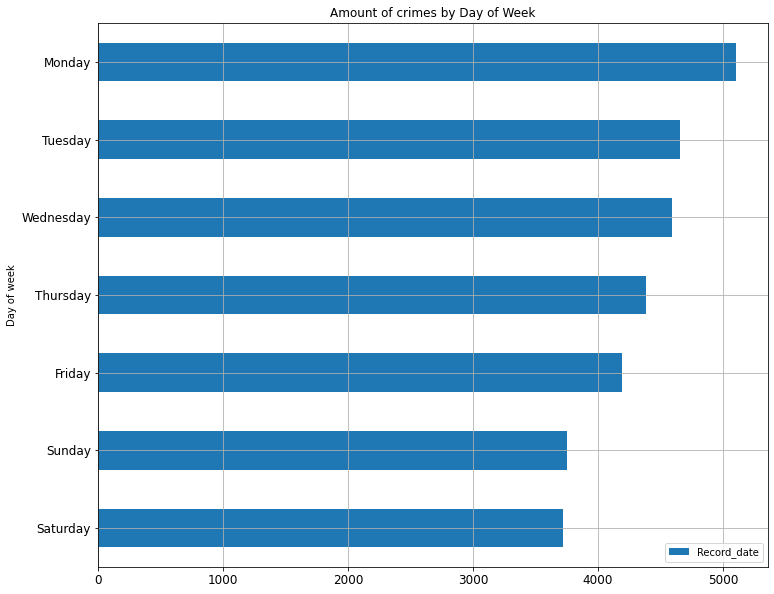

In [26]:
df_merge.groupby('Record_day_of_week')[['Record_date']].count().sort_values(by='Record_date', ascending=True).plot(kind='barh',
                                                                                                                   figsize=(12,10),
                                                                                                                   fontsize=12,
                                                                                                                   title='Amount of crimes by Day of Week',
                                                                                                                   xlabel='Day of week',
                                                                                                                   grid=True)
                                                                                                                  

In [27]:
df_merge.groupby('Administrative_district')[['Record_date']].count().sort_values(by=['Record_date'], ascending=False)

,Record_date
Administrative_district,
Pankow,4816
Mitte,4270
Friedrichshain-Kreuzberg,4196
Charlottenburg-Wilmersdorf,3349
Tempelhof-Schöneberg,2527
Treptow-Köpenick,2394
Neukölln,2374
Steglitz-Zehlendorf,1913
Lichtenberg,1705


<AxesSubplot:ylabel='Administrative_district'>

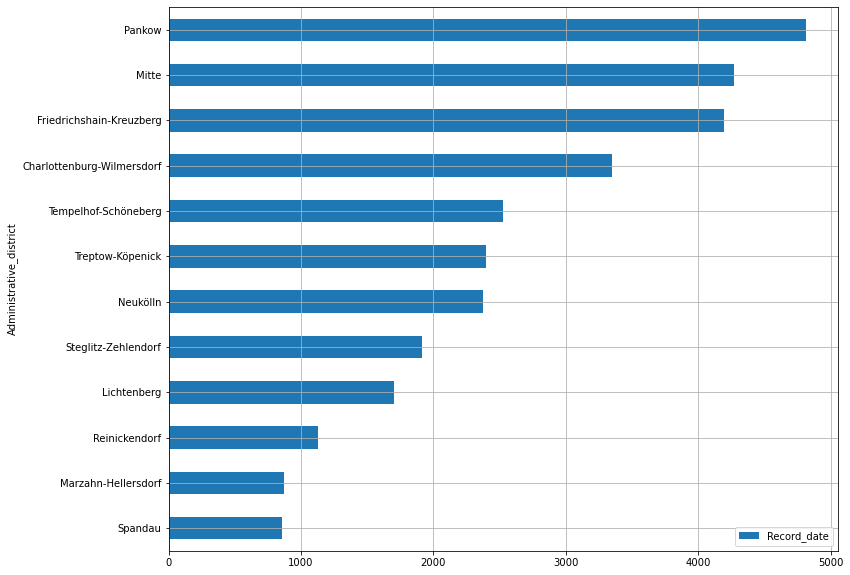

In [28]:
df_merge.groupby('Administrative_district')[['Record_date']].count().sort_values(by=['Record_date'], ascending=True).plot(kind='barh',
                                                                                                                          figsize=(12,10),
                                                                                                                          grid=True)

In [29]:
df_merge.groupby('Bike_type')[['Record_date']].count().sort_values(by='Record_date', ascending=False)

,Record_date
Bike_type,
Men,13975
Women,8892
Bike,4514
Mountain,1331
Child,1220
Racing,419
Cargo,45


In [30]:
df_merge.groupby('Crime_type')[['Record_date']].count().sort_values(by='Record_date', ascending=False)

,Record_date
Crime_type,
Theft,29081
Break-in,1315
